In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs
from matplotlib.colors import Normalize

In [6]:
tds = xr.open_dataset('tg_2014_2024.nc')
temp = xr.DataArray(tds['tg'])
lats = xr.DataArray(tds['latitude'])
lons = xr.DataArray(tds['longitude'])
time = xr.DataArray(tds['time'])

pds = xr.open_dataset('rr_2014_2024.nc')
prec = xr.DataArray(pds['rr'])

print(temp.shape, prec.shape, lats.shape, lons.shape, time.shape)

(3834, 465, 705) (3834, 465, 705) (465,) (705,) (3834,)


In [7]:
t_rain_min = 0
t_snow_max = 2

def prec_part(T, P):
    sff = 0
    rff = 0
    
    if P > 0:
        if T <= t_rain_min:
            sff = 1   
        elif T >= t_snow_max:
            sff = 0   
        else:
            # linear interpolation y=-0.5t+1, slope=-0.5, intercept=1 
            sff = -0.5*T + 1
            
        # min and max cap
        if sff > 1: sff = 1
        if sff < 0: sff = 0

        rff = 1-sff
        
    return float(sff), float(rff)

pp_vecfunc = np.vectorize(prec_part)

In [8]:
daily_sff_2015 = np.zeros((3834, 465, 705))

for t_idx in range(3834):
    sff = pp_vecfunc(temp[t_idx, :, :], prec[t_idx, :, :])
    daily_sff_2015[t_idx, :, :] = sff

daily_sff_2015.shape

(3834, 465, 705)

In [9]:
daily_sff_2015 = xr.DataArray(daily_sff_2015, dims=("time", "latitude", "longitude"),
    coords={"latitude": lats, "longitude": lons, "time": pd.to_datetime(time.values)})

# Assign hydrological year as a coordinate
daily_sff_2015 = daily_sff_2015.assign_coords(
    hydro_year=daily_sff_2015["time"].dt.year.where(daily_sff_2015["time"].dt.month >= 10, daily_sff_2015["time"].dt.year + 1)
)

# Apply condition (SFF > 0.4) to get snow days (1 = snow, 0 = no snow)
snow_days_2015 = (daily_sff_2015 > 0.75).astype(int)

# Debug print shapes
print("Original Shape:", daily_sff_2015.shape)  # (time, lat, lon)
print("Snow Days Shape:", snow_days_2015.shape)  # Should be the same as daily_sff_2000

# Group by hydrological year and sum over time
annual_snow_days_2015 = snow_days_2015.groupby("hydro_year").sum(dim="time", skipna=True)

# Debug print shape after aggregation - October 2014-Sept 2024 -> hydrological years of 2015-2024
print("Annual Snow Days Shape:", annual_snow_days_2015.shape)  # (hydro_year, lat, lon)


Original Shape: (3834, 465, 705)
Snow Days Shape: (3834, 465, 705)
Annual Snow Days Shape: (12, 465, 705)


In [69]:
# 10 water years of snow days
annual_snow_days_2015_2024 = annual_snow_days_2015.sel(hydro_year=slice(2015, 2024))
annual_snow_days_2015_2024_ltm = annual_snow_days_2015_2024.mean(dim="hydro_year")
annual_snow_days_2015_2024_ltm.shape

(465, 705)

In [27]:
tds = xr.open_dataset('tg_1999_2014.nc')
temp = xr.DataArray(tds['tg'])
lats = xr.DataArray(tds['latitude'])
lons = xr.DataArray(tds['longitude'])
time = xr.DataArray(tds['time'])

pds = xr.open_dataset('rr_1999_2014.nc')
prec = xr.DataArray(pds['rr'])

print(temp.shape, prec.shape, lats.shape, lons.shape, time.shape)

(5844, 465, 705) (5844, 465, 705) (465,) (705,) (5844,)


In [28]:
daily_sff_2000 = np.zeros((5844, 465, 705))

for t_idx in range(5844):
    sff = pp_vecfunc(temp[t_idx, :, :], prec[t_idx, :, :])
    daily_sff_2000[t_idx, :, :] = sff

daily_sff_2000.shape

(5844, 465, 705)

In [29]:
daily_sff_2000 = xr.DataArray(daily_sff_2000, dims=("time", "latitude", "longitude"),
    coords={"latitude": lats, "longitude": lons, "time": pd.to_datetime(time.values)})

# Assign hydrological year as a coordinate
daily_sff_2000 = daily_sff_2000.assign_coords(
    hydro_year=daily_sff_2000["time"].dt.year.where(daily_sff_2000["time"].dt.month >= 10, daily_sff_2000["time"].dt.year + 1)
)

# Apply condition (SFF > 0.4) to get snow days (1 = snow, 0 = no snow)
snow_days_2000 = (daily_sff_2000 > 0.4).astype(int)

# Debug print shapes
print("Original Shape:", daily_sff_2000.shape)  # (time, lat, lon)
print("Snow Days Shape:", snow_days_2000.shape)  # Should be the same as daily_sff_2000

# Group by hydrological year and sum over time
annual_snow_days_2000 = snow_days_2000.groupby("hydro_year").sum(dim="time", skipna=True)

# Debug print shape after aggregation - October 2014-Sept 2024 -> hydrological years of 2015-2024
print("Annual Snow Days Shape:", annual_snow_days_2000.shape)  # (hydro_year, lat, lon)


Original Shape: (5844, 465, 705)
Snow Days Shape: (5844, 465, 705)
Annual Snow Days Shape: (17, 465, 705)


In [68]:
annual_snow_days_2000_2014 = annual_snow_days_2000.sel(hydro_year=slice(2000, 2014))
annual_snow_days_2000_2014_ltm = annual_snow_days_2000_2014.mean(dim="hydro_year")
annual_snow_days_2000_2014_ltm.shape

(465, 705)

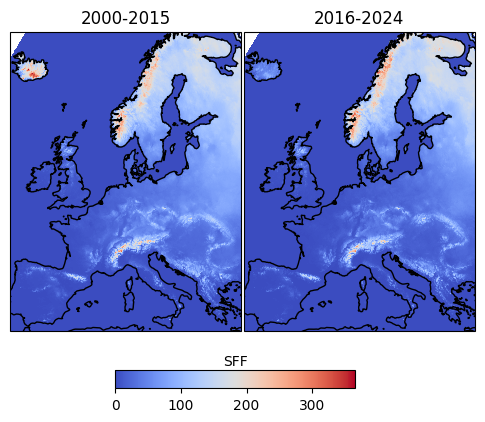

In [70]:
lon, lat = np.meshgrid(lons, lats)

min_lat = 35
max_lat = 71
min_lon = -8
max_lon = 25
clon = (min_lon + max_lon) / 2
clat = (min_lat + max_lat) / 2
europe_bbox = [min_lon, max_lon, min_lat, max_lat]

fig, axs = plt.subplots(1,2, figsize=(6,6), subplot_kw={'projection': ccrs.Orthographic(central_latitude=clat, central_longitude=clon)})
ax1 = axs[0]
ax2 = axs[1]
ax1.set_extent(europe_bbox, crs=ccrs.PlateCarree())
ax2.set_extent(europe_bbox, crs=ccrs.PlateCarree())
ax1.set_title('2000-2015', fontsize=12)
ax2.set_title('2016-2024', fontsize=12)
ax1.coastlines()
ax2.coastlines()

c1 = ax1.pcolormesh(lon, lat, annual_snow_days_2000_2014_ltm, cmap="coolwarm", transform=ccrs.PlateCarree())
c2 = ax2.pcolormesh(lon, lat, annual_snow_days_2015_2024_ltm, cmap="coolwarm", transform=ccrs.PlateCarree())

sm = ScalarMappable(cmap='coolwarm', norm=Normalize(vmin=0.0, vmax=365))  # Updated vmax to 0.7
sm.set_array([])
cax = fig.add_axes([0.3, 0.15, 0.4, 0.03])  # [left, bottom, width, height] 
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')

cbar.ax.tick_params(labelsize=10)  # Adjust tick size
cbar.ax.text(0.5, 1.5, 'SFF', fontsize=10, ha='center', va='center', transform=cbar.ax.transAxes)
fig.subplots_adjust(wspace=0.01, hspace=0)
plt.show()

In [74]:
annual_snow_days_2000_2014_nc = xr.DataArray(annual_snow_days_2000_2014, dims=("time", "latitude", "longitude"),
    coords={"latitude": lats, "longitude": lons, "time": range(2000, 2015)})
annual_snow_days_2000_2014_nc.to_netcdf('snow_days_2000_2014.nc') 

annual_snow_days_2015_2024_nc = xr.DataArray(annual_snow_days_2015_2024, dims=("time", "latitude", "longitude"),
    coords={"latitude": lats, "longitude": lons, "time": range(2015, 2025)})
annual_snow_days_2015_2024_nc.to_netcdf('snow_days_2015_2024.nc') 

In [4]:
sd1_file = 'rivers/snow_days_basin_wise_2000_2014.csv'
sd1 = pd.read_csv(sd1_file)
sd1 = sd1.drop(columns=['MEAN', 'CLASS'])

# find average over 2000-2014 and classify
sd1["MEAN"] = sd1.iloc[:, 3:].mean(axis=1)
# if sff > 0.5, SD, sff > 0 and <0.5, SRD, remaining RD
sd1["CLASS"] = sd1["MEAN"].apply(lambda x: "SD" if x >= 30 else "SRD")
sd1.loc[sd1["MEAN"] == 0, "CLASS"] = "RD"
sd1 = sd1.dropna(subset=['MEAN', 'CLASS'])
sd1.to_csv(sd1_file, index=False)

river_counts = sd1.groupby('CLASS')['RIVERBASIN'].nunique()
print("Number of rivers by class during 2000-2014:", river_counts)

Number of rivers by class during 2000-2014: CLASS
SD     34
SRD    42
Name: RIVERBASIN, dtype: int64


In [5]:
sd2_file = 'rivers/snow_days_basin_wise_2015_2024.csv'
sd2 = pd.read_csv(sd2_file)
sd2 = sd2.drop(columns=['MEAN', 'CLASS'])

# find average over 1950-2024 and classify
sd2["MEAN"] = sd2.iloc[:, 3:].mean(axis=1)
# if sff > 0.5, SD, sff > 0 and <0.5, SRD, remaining RD
sd2["CLASS"] = sd2["MEAN"].apply(lambda x: "SD" if x >= 30 else "SRD")
sd2.loc[sd2["MEAN"] == 0, "CLASS"] = "RD"
sd2 = sd2.dropna(subset=['MEAN', 'CLASS'])
sd2.to_csv(sd2_file, index=False)

river_counts = sd2.groupby('CLASS')['RIVERBASIN'].nunique()
print("Number of rivers by class during 2015_2024:", river_counts)

Number of rivers by class during 2015_2024: CLASS
SD     25
SRD    51
Name: RIVERBASIN, dtype: int64


In [6]:
# finding rivers which were SD during 1950-2024 became SRD during 2000-2024
d1 = sd1[sd1["CLASS"] == "SD"]
d2 = sd2[sd2["CLASS"] == "SRD"]
transition_rivers = pd.merge( d1[["RIVERBASIN"]], d2[["RIVERBASIN"]], on="RIVERBASIN")
print(transition_rivers)

                          RIVERBASIN
0                  JOKULSA A FJOLLUM
1                         LAGARFLJOT
2                              MEZEN
3                             SVARTA
4                            DNIEPER
5                                DON
6  NEMAN (also NEMUNAS, also NYOMAN)
7                             OLFUSA
8                            THJORSA


In [ ]:
if SF>60% for more than 30 days, WS is SD. 
SD->SRD
0                  JOKULSA A FJOLLUM iceland
1                         LAGARFLJOT iceland
2                              MEZEN russia
3                             SVARTA iceland
4                                DON russia
5                            DNIEPER russia
6  NEMAN (also NEMUNAS, also NYOMAN) belarus
7                             OLFUSA iceland
8                            THJORSA iceland

Most icelandic watersheds have less snow days during the period. 
if compared with 1950-1999 period, river Rhone once under SD is under SRD now since 2016.

In [80]:
# sd1_file = 'snow_days_basin_wise_2000_2014.csv'
# sd1 = pd.read_csv(sd1_file)
# sd1 = sd1.drop(columns=['MEAN', 'CLASS'])

# # find average over 2000-2014 and classify
# sd1["MEAN"] = sd1.iloc[:, 3:].mean(axis=1)
# # if sff > 0.5, SD, sff > 0 and <0.5, SRD, remaining RD
# sd1["CLASS"] = sd1["MEAN"].apply(lambda x: "SD" if x >= 20 else "SRD")
# sd1.loc[sd1["MEAN"] == 0, "CLASS"] = "RD"
# sd1 = sd1.dropna(subset=['MEAN', 'CLASS'])
# sd1.to_csv(sd1_file, index=False)

# river_counts = sd1.groupby('CLASS')['RIVERBASIN'].nunique()
# print("Number of rivers by class during 2000-2014:", river_counts)

Number of rivers by class during 2000-2014: CLASS
SD     46
SRD    30
Name: RIVERBASIN, dtype: int64


In [81]:
# sd2_file = 'snow_days_basin_wise_2015_2024.csv'
# sd2 = pd.read_csv(sd2_file)
# sd2 = sd2.drop(columns=['MEAN', 'CLASS'])

# # find average over 1950-2024 and classify
# sd2["MEAN"] = sd2.iloc[:, 3:].mean(axis=1)
# # if sff > 0.5, SD, sff > 0 and <0.5, SRD, remaining RD
# sd2["CLASS"] = sd2["MEAN"].apply(lambda x: "SD" if x >= 20 else "SRD")
# sd2.loc[sd2["MEAN"] == 0, "CLASS"] = "RD"
# sd2 = sd2.dropna(subset=['MEAN', 'CLASS'])
# sd2.to_csv(sd2_file, index=False)

# river_counts = sd2.groupby('CLASS')['RIVERBASIN'].nunique()
# print("Number of rivers by class during 2015_2024:", river_counts)

Number of rivers by class during 2015_2024: CLASS
SD     38
SRD    38
Name: RIVERBASIN, dtype: int64


In [82]:
# # finding rivers which were SD during 1950-2024 became SRD during 2000-2024
# d1 = sd1[sd1["CLASS"] == "SD"]
# d2 = sd2[sd2["CLASS"] == "SRD"]
# transition_rivers = pd.merge( d1[["RIVERBASIN"]], d2[["RIVERBASIN"]], on="RIVERBASIN")
# print(transition_rivers)

                         RIVERBASIN
0                            DANUBE
1                              ELBE
2               NESTOS (also MESTA)
3                              ODER
4                            OLFUSA
5  PIVDENNY BUH (also SOUTHERN BUG)
6                             RHINE
7                           VISTULA


In [ ]:
if SF>60% for more than 20 days, WS is SD->SRD. 
                          RIVERBASIN
4                             DANUBE germany
5                               ELBE germany
6                NESTOS (also MESTA) greece
7                               ODER poland
8                             OLFUSA iceland
9   PIVDENNY BUH (also SOUTHERN BUG) ukraine
10                             RHINE germany
12                           VISTULA poland

Many major Central European watersheds receive heavy snowfall for between 20-25 days in a year.

In [114]:
# anomalies of snow days 2015-2024
annual_snow_days_2015_2024_ltm = annual_snow_days_2015_2024.mean(dim="hydro_year")
snow_days_anom = annual_snow_days_2015_2024 - annual_snow_days_2015_2024_ltm
snow_days_anom.shape

(10, 465, 705)

In [115]:
snow_days_anom_nc = xr.DataArray(snow_days_anom, dims=("time", "latitude", "longitude"),
    coords={"latitude": lats, "longitude": lons, "time": range(2015, 2025)})
snow_days_anom_nc.to_netcdf('snow_days_anom.nc') 

In [116]:
# Compute mean anomaly over the period 2015-2024
mean_anomaly = snow_days_anom.mean(dim="hydro_year")

# Compute standard deviation (variation) over the period
std_anomaly = snow_days_anom.std(dim="hydro_year")

# Print shapes for verification
print("Mean Anomaly Shape:", mean_anomaly.shape)  # (lat, lon)
print("Standard Deviation Shape:", std_anomaly.shape)  # (lat, lon)

Mean Anomaly Shape: (465, 705)
Standard Deviation Shape: (465, 705)


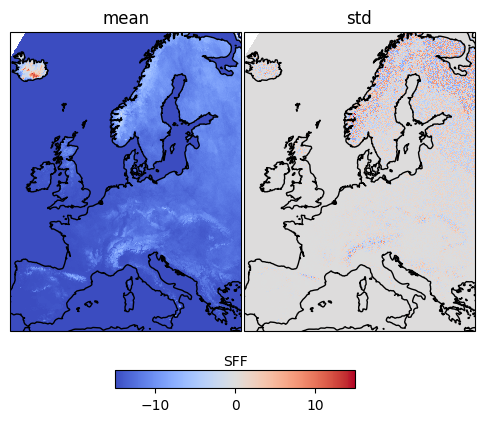

In [117]:
fig, axs = plt.subplots(1,2, figsize=(6,6), subplot_kw={'projection': ccrs.Orthographic(central_latitude=clat, central_longitude=clon)})
ax1 = axs[0]
ax2 = axs[1]
ax1.set_extent(europe_bbox, crs=ccrs.PlateCarree())
ax2.set_extent(europe_bbox, crs=ccrs.PlateCarree())
ax1.set_title('mean', fontsize=12)
ax2.set_title('std', fontsize=12)
ax1.coastlines()
ax2.coastlines()

c1 = ax1.pcolormesh(lon, lat, std_anomaly, cmap="coolwarm", transform=ccrs.PlateCarree())
c2 = ax2.pcolormesh(lon, lat, mean_anomaly, cmap="coolwarm", transform=ccrs.PlateCarree())

sm = ScalarMappable(cmap='coolwarm', norm=Normalize(vmin=-15, vmax=15))  # Updated vmax to 0.7
sm.set_array([])
cax = fig.add_axes([0.3, 0.15, 0.4, 0.03])  # [left, bottom, width, height] 
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')

cbar.ax.tick_params(labelsize=10)  # Adjust tick size
cbar.ax.text(0.5, 1.5, 'SFF', fontsize=10, ha='center', va='center', transform=cbar.ax.transAxes)
fig.subplots_adjust(wspace=0.01, hspace=0)
plt.show()

In [7]:
# snow days anomalies for each river
anomfile = 'rivers/snow_days_anom.csv'
anom = pd.read_csv(anomfile)
anom.head

# finding rivers which were SD during 1950-2024 became SRD during 2000-2024
merged_df = anom.merge(sd2[['MRBID', 'MEAN', 'CLASS']], on="MRBID", how="left")  
merged_df.head(20)

,MRBID,RIVERBASIN,AREA,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,MEAN,CLASS
0,2201,ORONTES,46950.318558,-0.980493,1.641442,0.343713,0.029990,-0.703776,-0.053198,0.276051,-0.684033,0.932792,-0.802490,1.122698,SRD
1,2904,DEAD SEA,54249.876700,-0.187176,0.448800,0.147115,0.105224,-0.166062,-0.075842,0.118734,-0.196777,0.010422,-0.204439,0.206354,SRD
2,6101,JOKULSA A FJOLLUM,7600.055355,86.400671,69.185801,31.021093,-26.658224,-26.658224,-26.658224,-26.658224,-26.658224,-26.658224,-26.658224,26.658224,SRD
3,6102,KEM,42365.568932,-12.975604,10.024786,10.328546,-17.387193,13.985934,6.649157,17.215094,-3.354299,1.181731,-25.668154,72.426188,SD
4,6103,KOVDA,10414.848961,-7.111029,12.889107,3.093829,-12.422000,10.904165,12.004964,13.723243,-0.860045,-7.762241,-24.459993,71.303716,SD
5,6104,LAGARFLJOT,3332.560375,63.892029,56.996456,35.299808,-22.312613,-22.312613,-22.312613,-22.312613,-22.312613,-22.312613,-22.312613,22.312613,SRD
6,6105,MEZEN,77249.002341,20.303547,16.067413,12.288738,22.174036,-0.974978,10.578546,-20.109325,-20.109325,-20.109325,-20.109325,20.109325,SRD
7,6106,ONEGA,63244.662170,13.279394,21.029476,13.115371,8.236803,4.232730,13.585104,-3.770753,-20.392269,-14.019876,-35.295981,63.389757,SD
8,6107,PECHORA,316307.287516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,6108,PONOY,14345.611960,-1.537338,-0.214197,-2.887013,9.863418,1.789372,8.205663,18.245470,0.849387,-0.624209,-33.690554,80.722559,SD


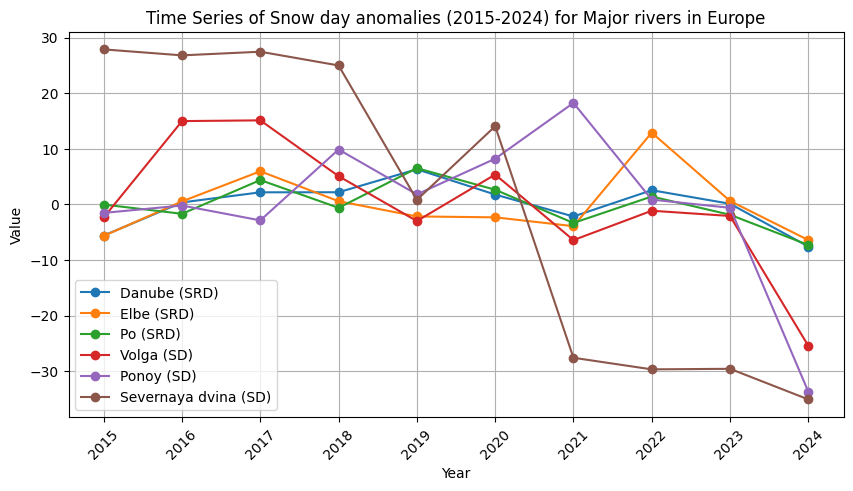

In [9]:
years = range(2015, 2025)

# Plot the time series
plt.figure(figsize=(10, 5))

rivers = [
    "DANUBE", "ELBE", "PO", 
    "VOLGA", "PONOY", "SEVERNAYA DVINA"]

for river in rivers:
    val = merged_df[merged_df["RIVERBASIN"] == river]
    plt.plot(years, val.iloc[:, 3:13].values.flatten(), marker="o", linestyle="-", label=f"{river.capitalize()} ({val['CLASS'].values[0]})")

# Formatting
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Time Series of Snow day anomalies (2015-2024) for Major rivers in Europe")
plt.xticks(years, rotation=45)
plt.grid()
plt.legend()
plt.show()

In [ ]:
Snow dominated rivers show less anomalies compared to snow-rain dominated rivers
1. Does this mean - snowfall is reducing and rainfall is increasing?
